# Get the Data

In [85]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from mpl_toolkits.mplot3d import Axes3D

from pandas.plotting import scatter_matrix
import math

In [86]:
import tensorflow as tf
#from tensorflow import keras
import keras
print(tf.__version__)
print(keras.__version__)

2.16.1
3.0.5


## Define global constants

In [87]:
#MY_OPTIMIZER = "SGD"
# MY_EPOCHS = 1000
# MY_LEARNING_RATE = 0.000001
# MY_BATCH_SIZE = 2048
MY_EPOCHS = 1000
MY_LEARNING_RATE = 0.0001
MY_BATCH_SIZE = 32

# Get the Data

In [88]:
maneuvers = pd.read_csv("maneuvers_cntrl_T8.csv")
#maneuvers.head()
maneuvers.shape

(1000, 7)

In [89]:
maneuvers.describe()

,x,y,z,dx,dy,dz,dv_st
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1.000000e+03
mean,-0.991457,0.003326,0.000535,0.001314,0.006450,-0.001704,-2.194487e-07
std,0.000029,0.000029,0.000028,0.000029,0.000029,0.000029,1.019808e-04
min,-0.991507,0.003277,0.000485,0.001264,0.006400,-0.001753,-2.455222e-04
25%,-0.991484,0.003301,0.000514,0.001290,0.006425,-0.001729,-8.353207e-05
50%,-0.991457,0.003326,0.000536,0.001314,0.006450,-0.001705,-4.591273e-06
75%,-0.991432,0.003350,0.000559,0.001339,0.006474,-0.001678,8.811727e-05
max,-0.991408,0.003377,0.000585,0.001363,0.006500,-0.001654,2.241872e-04


## Add/Drop Features

Try adding new attribute "angle" = angle in the periodic orbit, which is essentially time/period.

In [90]:
# Drop dx and dz features, since they are almost proportional to y
#maneuvers = maneuvers.drop(["dx", "dz"], axis=1)

#maneuvers["angle"]=maneuvers["t"].apply(lambda x: math.fmod(x, 0.3059226605957322E+01))
#maneuvers = maneuvers.drop(["t"], axis=1)


# Prepare the Data for Machine Learning Algorithms

In [91]:
# Let's separate the predictors and the labels
maneuvers_predictors = maneuvers.drop("dv_st", axis=1)
maneuvers_labels = maneuvers[["dv_st"]].copy()

# Convert dataframe to a numpy array before training, to avoid issues with dataframe headers.
maneuvers_predictors = maneuvers_predictors.to_numpy()
maneuvers_labels = maneuvers_labels.to_numpy()

#maneuvers_predictors.head()
#maneuvers_labels.head()

## Create a Train/Test/Validation Set

In [92]:
X_train_full, X_test, y_train_full, y_test = train_test_split(
maneuvers_predictors, maneuvers_labels, test_size=0.2, random_state=1)
X_train, X_valid, y_train, y_valid = train_test_split(
X_train_full, y_train_full)
print(X_train.shape)
print(X_test.shape)
print(X_valid.shape)
print(X_train[:4])

(600, 6)
(200, 6)
(200, 6)
[[-9.91488717e-01  3.30267825e-03  5.21903315e-04  1.28661917e-03
   6.43028023e-03 -1.74095460e-03]
 [-9.91470926e-01  3.37581469e-03  5.59519686e-04  1.33128960e-03
   6.42200089e-03 -1.70509827e-03]
 [-9.91503703e-01  3.31930338e-03  5.15214671e-04  1.36023035e-03
   6.45653146e-03 -1.72544082e-03]
 [-9.91418844e-01  3.29295024e-03  5.60714299e-04  1.30394353e-03
   6.45690927e-03 -1.68041160e-03]]


In [93]:
# Scale all the features
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_valid_scaled = scaler.transform(X_valid)
X_test_scaled = scaler.transform(X_test)

X_train_scaled[:5]

array([[0.186718  , 0.25437954, 0.37270123, 0.2296429 , 0.29887338,
        0.12512534],
       [0.36491439, 0.98723332, 0.75326441, 0.67859269, 0.21590149,
        0.48392011],
       [0.03662525, 0.42096944, 0.30503251, 0.96945497, 0.5619513 ,
        0.28036334],
       [0.88655652, 0.15690138, 0.76535026, 0.40375741, 0.56573759,
        0.73094614],
       [0.87184899, 0.75572447, 0.0388984 , 0.39533121, 0.49455512,
        0.01024304]])

In [94]:
# Scale target variable dv_st as well.
# Rationale: dv_st takes very small values (10^{-8}), 
# so MSE may be tiny and not computed properly. Also, NN may converge faster?

scaler_target = MinMaxScaler()
y_train_scaled = scaler_target.fit_transform(y_train)
y_valid_scaled = scaler_target.transform(y_valid)
y_test_scaled = scaler_target.transform(y_test)
y_train_scaled[:5]

array([[0.84212026],
       [0.57464902],
       [0.77315851],
       [0.29229324],
       [0.25549822]])

In [95]:
# Try adding degree 2 polynomial features. This worked well for polynomial regression 
# (see supervised.py).
from sklearn.preprocessing import PolynomialFeatures
poly_features = PolynomialFeatures(degree=2, include_bias=False)
X_train_scaled = poly_features.fit_transform(X_train_scaled)
X_valid_scaled = poly_features.transform(X_valid_scaled)
X_test_scaled = poly_features.transform(X_test_scaled)

X_train_scaled[:5]

array([[1.86718005e-01, 2.54379544e-01, 3.72701227e-01, 2.29642896e-01,
        2.98873375e-01, 1.25125343e-01, 3.48636132e-02, 4.74972409e-02,
        6.95900294e-02, 4.28784633e-02, 5.58050402e-02, 2.33631544e-02,
        6.47089524e-02, 9.48075681e-02, 5.84164552e-02, 7.60272729e-02,
        3.18293277e-02, 1.38906204e-01, 8.55881891e-02, 1.11390474e-01,
        4.66343689e-02, 5.27358597e-02, 6.86341474e-02, 2.87341462e-02,
        8.93252944e-02, 3.73966336e-02, 1.56563515e-02],
       [3.64914394e-01, 9.87233319e-01, 7.53264413e-01, 6.78592691e-01,
        2.15901493e-01, 4.83920114e-01, 1.33162515e-01, 3.60255648e-01,
        2.74877026e-01, 2.47628240e-01, 7.87855623e-02, 1.76589415e-01,
        9.74629627e-01, 7.43647726e-01, 6.69929315e-01, 2.13145147e-01,
        4.77742060e-01, 5.67407275e-01, 5.11159725e-01, 1.62630911e-01,
        3.64519800e-01, 4.60488040e-01, 1.46509175e-01, 3.28384652e-01,
        4.66134545e-02, 1.04479075e-01, 2.34178677e-01],
       [3.66252533e-02

In [96]:
import joblib
joblib.dump(scaler, 'scaler.gz')
joblib.dump(scaler_target, 'scaler_target.gz')

['scaler_target.gz']

In [97]:
cov=np.cov(X_train_scaled, rowvar=False)
cond = np.linalg.cond(cov)
max_eig = np.linalg.eigvals(cov).max()
print(f"condition number is {cond}, max eigenvalue {max_eig:.2f}")

condition number is 378.01166879901865, max eigenvalue 0.36


# Building, Training, and Evaluating the Model

The output layer has a single neuron (since we only want to
predict a single value) and uses no activation function, and the loss function is the mean squared error. 

Since the dataset is quite noisy, we just use a single hidden layer with fewer neurons than before, to avoid overfitting.

In [98]:
model = keras.models.Sequential([
keras.layers.Dense(300, activation="relu", input_shape=X_train_scaled.shape[1:]),
keras.layers.Dense(100, activation="relu"),
keras.layers.Dense(1)
])
model.summary()

/home/pablo/anaconda3/envs/halo/lib/python3.12/site-packages/keras/src/layers/core/dense.py:85: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_12 (Dense)                │ (None, 300)            │         8,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 100)            │        30,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 1)              │           101 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 38,601 (150.79 KB)

 Trainable params: 38,601 (150.79 KB)

 Non-trainable params: 0 (0.00 B)

In [99]:
#opt = keras.optimizers.SGD(learning_rate=MY_LEARNING_RATE)
opt = keras.optimizers.Adam(learning_rate=MY_LEARNING_RATE)
model.compile(loss="mean_squared_error", optimizer=opt)
history = model.fit(X_train_scaled, y_train_scaled, epochs=MY_EPOCHS, batch_size=MY_BATCH_SIZE,
                    validation_data=(X_valid_scaled, y_valid_scaled))

Epoch 1/1000
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.3341 - val_loss: 0.1502
Epoch 2/1000
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1348 - val_loss: 0.0952
Epoch 3/1000
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0866 - val_loss: 0.0834
Epoch 4/1000
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0828 - val_loss: 0.0691
Epoch 5/1000
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0660 - val_loss: 0.0573
Epoch 6/1000
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0609 - val_loss: 0.0472
Epoch 7/1000
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0462 - val_loss: 0.0388
Epoch 8/1000
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0386 - val_loss: 0.0318
Epoch 9/1000
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0330 - val_loss: 0.0259
Epoch 10/1000
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0258 - val_loss: 0.0209
Epoch 11/1000
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0181 - val_loss: 0.0169
Epoch 12/1000
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/ste

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.7387e-04 - val_loss: 2.6878e-04
Epoch 67/1000
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.3623e-04 - val_loss: 2.5342e-04
Epoch 68/1000
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.1327e-04 - val_loss: 2.4553e-04
Epoch 69/1000
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.5641e-04 - val_loss: 2.4976e-04
Epoch 70/1000
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.4911e-04 - val_loss: 2.3702e-04
Epoch 71/1000
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.1718e-04 - val_loss: 2.3334e-04
Epoch 72/1000
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.6821e-04 - val_loss: 2.2074e-04
Epoch 73/1000
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.6245e-04 - val_loss: 2.2190e-04
Epoch 74/1000
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.1031e-04 - val_loss: 2.1408e-04
Epoch 75/1000
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.4635e-04 - val_loss: 2.1099e-04
Epoch 76/1000
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.5

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3.8002e-05 - val_loss: 1.4049e-04
Epoch 130/1000
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4.2492e-05 - val_loss: 1.3892e-04
Epoch 131/1000
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3.9707e-05 - val_loss: 1.4129e-04
Epoch 132/1000
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3.4288e-05 - val_loss: 1.3967e-04
Epoch 133/1000
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4.1377e-05 - val_loss: 1.3861e-04
Epoch 134/1000
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3.5868e-05 - val_loss: 1.3813e-04
Epoch 135/1000
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3.3754e-05 - val_loss: 1.4354e-04
Epoch 136/1000
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3.7190e-05 - val_loss: 1.3767e-04
Epoch 137/1000
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3.3896e-05 - val_loss: 1.3728e-04
Epoch 138/1000
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3.5335e-05 - val_loss: 1.4065e-04
Epoch 139/1000
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step -

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.4332e-05 - val_loss: 1.2415e-04
Epoch 193/1000
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.5522e-05 - val_loss: 1.2560e-04
Epoch 194/1000
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.3954e-05 - val_loss: 1.2388e-04
Epoch 195/1000
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.5738e-05 - val_loss: 1.2331e-04
Epoch 196/1000
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.4434e-05 - val_loss: 1.2359e-04
Epoch 197/1000
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.5282e-05 - val_loss: 1.2502e-04
Epoch 198/1000
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.7445e-05 - val_loss: 1.2479e-04
Epoch 199/1000
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.5242e-05 - val_loss: 1.2092e-04
Epoch 200/1000
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.3700e-05 - val_loss: 1.2180e-04
Epoch 201/1000
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.3458e-05 - val_loss: 1.2313e-04
Epoch 202/1000
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step -

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 9.4305e-06 - val_loss: 1.1568e-04
Epoch 256/1000
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 6.6761e-06 - val_loss: 1.1505e-04
Epoch 257/1000
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 7.3870e-06 - val_loss: 1.1273e-04
Epoch 258/1000
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 8.5757e-06 - val_loss: 1.1618e-04
Epoch 259/1000
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 8.8293e-06 - val_loss: 1.1396e-04
Epoch 260/1000
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 7.5471e-06 - val_loss: 1.1556e-04
Epoch 261/1000
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 7.6309e-06 - val_loss: 1.1806e-04
Epoch 262/1000
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 8.0345e-06 - val_loss: 1.1450e-04
Epoch 263/1000
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 6.2956e-06 - val_loss: 1.1678e-04
Epoch 264/1000
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 7.2845e-06 - val_loss: 1.1535e-04
Epoch 265/1000
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step -

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3.3107e-06 - val_loss: 1.1144e-04
Epoch 319/1000
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3.4394e-06 - val_loss: 1.1063e-04
Epoch 320/1000
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3.7124e-06 - val_loss: 1.1129e-04
Epoch 321/1000
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3.6145e-06 - val_loss: 1.1403e-04
Epoch 322/1000
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4.5801e-06 - val_loss: 1.1109e-04
Epoch 323/1000
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3.4071e-06 - val_loss: 1.1447e-04
Epoch 324/1000
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 5.3856e-06 - val_loss: 1.0988e-04
Epoch 325/1000
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.9930e-06 - val_loss: 1.0963e-04
Epoch 326/1000
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 3.0664e-06 - val_loss: 1.1384e-04
Epoch 327/1000
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4.6856e-06 - val_loss: 1.1211e-04
Epoch 328/1000
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step -

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 2.9118e-06 - val_loss: 1.0540e-04
Epoch 382/1000
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.8711e-06 - val_loss: 1.0834e-04
Epoch 383/1000
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.4745e-06 - val_loss: 1.0732e-04
Epoch 384/1000
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.2828e-06 - val_loss: 1.0824e-04
Epoch 385/1000
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 2.6652e-06 - val_loss: 1.0684e-04
Epoch 386/1000
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3.6069e-06 - val_loss: 1.0705e-04
Epoch 387/1000
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.2361e-06 - val_loss: 1.1491e-04
Epoch 388/1000
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 8.7656e-06 - val_loss: 1.1308e-04
Epoch 389/1000
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 9.0466e-06 - val_loss: 1.1048e-04
Epoch 390/1000
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4.3374e-06 - val_loss: 1.0851e-04
Epoch 391/1000
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step -

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3.4672e-06 - val_loss: 1.0439e-04
Epoch 445/1000
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.1756e-06 - val_loss: 1.0444e-04
Epoch 446/1000
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.3239e-06 - val_loss: 1.0501e-04
Epoch 447/1000
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.6934e-06 - val_loss: 1.0348e-04
Epoch 448/1000
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.0501e-06 - val_loss: 1.0430e-04
Epoch 449/1000
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 9.0549e-07 - val_loss: 1.0349e-04
Epoch 450/1000
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 9.4548e-07 - val_loss: 1.0454e-04
Epoch 451/1000
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.9491e-06 - val_loss: 1.0423e-04
Epoch 452/1000
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.5524e-06 - val_loss: 1.0591e-04
Epoch 453/1000
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.1293e-06 - val_loss: 1.0646e-04
Epoch 454/1000
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step -

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.6850e-06 - val_loss: 1.0346e-04
Epoch 508/1000
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.6427e-06 - val_loss: 1.0576e-04
Epoch 509/1000
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.4539e-06 - val_loss: 1.0331e-04
Epoch 510/1000
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.4703e-06 - val_loss: 1.0395e-04
Epoch 511/1000
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.7342e-06 - val_loss: 1.0497e-04
Epoch 512/1000
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.4423e-06 - val_loss: 1.0488e-04
Epoch 513/1000
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.1361e-06 - val_loss: 1.0197e-04
Epoch 514/1000
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.1336e-06 - val_loss: 1.0453e-04
Epoch 515/1000
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.2048e-06 - val_loss: 1.0264e-04
Epoch 516/1000
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.3387e-06 - val_loss: 1.0535e-04
Epoch 517/1000
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step -

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4.6987e-07 - val_loss: 1.0159e-04
Epoch 571/1000
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.5226e-07 - val_loss: 1.0157e-04
Epoch 572/1000
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4.2945e-07 - val_loss: 1.0145e-04
Epoch 573/1000
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.1411e-06 - val_loss: 1.0048e-04
Epoch 574/1000
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.7190e-06 - val_loss: 1.0142e-04
Epoch 575/1000
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.1642e-06 - val_loss: 1.0163e-04
Epoch 576/1000
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 6.5342e-07 - val_loss: 1.0361e-04
Epoch 577/1000
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.6349e-06 - val_loss: 1.0567e-04
Epoch 578/1000
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.3667e-06 - val_loss: 1.0448e-04
Epoch 579/1000
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.0668e-06 - val_loss: 1.0584e-04
Epoch 580/1000
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step -

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 8.4664e-07 - val_loss: 1.0054e-04
Epoch 634/1000
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4.6056e-07 - val_loss: 9.9795e-05
Epoch 635/1000
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 7.1335e-07 - val_loss: 1.0434e-04
Epoch 636/1000
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.5930e-06 - val_loss: 9.8973e-05
Epoch 637/1000
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4.8169e-07 - val_loss: 1.0066e-04
Epoch 638/1000
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 6.1938e-07 - val_loss: 9.9341e-05
Epoch 639/1000
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 9.1743e-07 - val_loss: 1.0275e-04
Epoch 640/1000
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 9.1658e-07 - val_loss: 1.0089e-04
Epoch 641/1000
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.8494e-06 - val_loss: 1.0036e-04
Epoch 642/1000
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.0544e-06 - val_loss: 1.0218e-04
Epoch 643/1000
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step -

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.9571e-07 - val_loss: 9.9268e-05
Epoch 697/1000
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.7870e-07 - val_loss: 9.8826e-05
Epoch 698/1000
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 5.3729e-07 - val_loss: 9.9775e-05
Epoch 699/1000
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 7.2024e-07 - val_loss: 1.0086e-04
Epoch 700/1000
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 2.6323e-06 - val_loss: 1.0898e-04
Epoch 701/1000
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 7.0920e-06 - val_loss: 1.0167e-04
Epoch 702/1000
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 2.7093e-05 - val_loss: 1.8105e-04
Epoch 703/1000
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 5.4119e-05 - val_loss: 1.2231e-04
Epoch 704/1000
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.1973e-05 - val_loss: 1.0408e-04
Epoch 705/1000
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 6.3433e-06 - val_loss: 1.1173e-04
Epoch 706/1000
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step -

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4.1070e-07 - val_loss: 9.9672e-05
Epoch 760/1000
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 7.6411e-07 - val_loss: 1.0125e-04
Epoch 761/1000
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.3676e-06 - val_loss: 9.8805e-05
Epoch 762/1000
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 7.5046e-07 - val_loss: 9.9081e-05
Epoch 763/1000
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 5.8800e-07 - val_loss: 9.8616e-05
Epoch 764/1000
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.2848e-06 - val_loss: 9.8807e-05
Epoch 765/1000
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.1396e-06 - val_loss: 9.7696e-05
Epoch 766/1000
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.9878e-06 - val_loss: 9.8078e-05
Epoch 767/1000
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3.0918e-06 - val_loss: 9.6632e-05
Epoch 768/1000
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4.0823e-06 - val_loss: 1.0486e-04
Epoch 769/1000
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step -

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.8126e-07 - val_loss: 9.8772e-05
Epoch 823/1000
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 6.1372e-07 - val_loss: 9.8204e-05
Epoch 824/1000
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 5.7540e-07 - val_loss: 9.6863e-05
Epoch 825/1000
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 7.7071e-07 - val_loss: 9.7963e-05
Epoch 826/1000
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.0057e-06 - val_loss: 9.7192e-05
Epoch 827/1000
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 9.9938e-07 - val_loss: 1.0721e-04
Epoch 828/1000
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4.5556e-06 - val_loss: 9.8789e-05
Epoch 829/1000
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.3067e-06 - val_loss: 9.9632e-05
Epoch 830/1000
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4.0098e-06 - val_loss: 1.0395e-04
Epoch 831/1000
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 5.6218e-06 - val_loss: 1.0246e-04
Epoch 832/1000
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step -

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.8067e-07 - val_loss: 9.6872e-05
Epoch 886/1000
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.9876e-07 - val_loss: 9.7741e-05
Epoch 887/1000
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 3.3066e-07 - val_loss: 9.7714e-05
Epoch 888/1000
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 5.3326e-07 - val_loss: 9.8429e-05
Epoch 889/1000
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.0352e-06 - val_loss: 9.8515e-05
Epoch 890/1000
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 9.2084e-07 - val_loss: 9.7687e-05
Epoch 891/1000
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 9.0610e-07 - val_loss: 9.9857e-05
Epoch 892/1000
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 8.5463e-07 - val_loss: 9.6747e-05
Epoch 893/1000
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 9.8188e-07 - val_loss: 9.9492e-05
Epoch 894/1000
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 8.5777e-07 - val_loss: 9.8536e-05
Epoch 895/1000
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step -

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3.3628e-06 - val_loss: 1.0244e-04
Epoch 949/1000
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 8.0528e-06 - val_loss: 1.2087e-04
Epoch 950/1000
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.3599e-05 - val_loss: 1.1897e-04
Epoch 951/1000
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.3126e-05 - val_loss: 1.0683e-04
Epoch 952/1000
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.2928e-05 - val_loss: 1.0003e-04
Epoch 953/1000
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 6.5880e-06 - val_loss: 1.0079e-04
Epoch 954/1000
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4.0517e-06 - val_loss: 9.7913e-05
Epoch 955/1000
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.3690e-06 - val_loss: 9.9841e-05
Epoch 956/1000
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.8794e-06 - val_loss: 9.7536e-05
Epoch 957/1000
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.7000e-06 - val_loss: 9.7545e-05
Epoch 958/1000
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step -

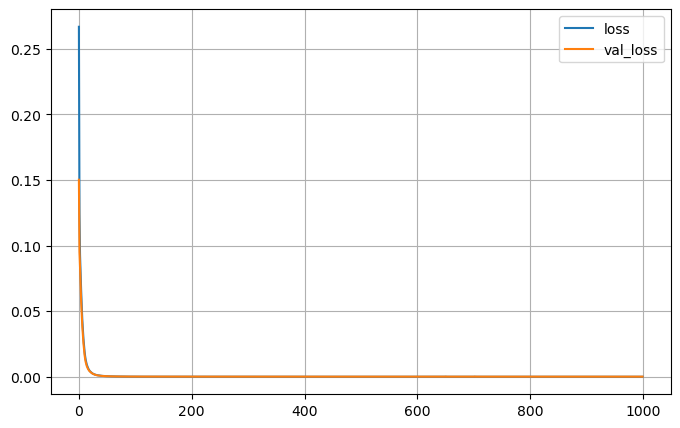

In [100]:
# Plot learning curves
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
#plt.gca().set_ylim(0, 5e-4) # set the vertical range to [0-1]
plt.show()

In [101]:
mse_test = model.evaluate(X_test_scaled, y_test_scaled)
np.sqrt(mse_test)

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.1048e-04 


0.011678712967257527

In [102]:
X_new = X_test_scaled[:3] # pretend these are new instances
y_pred = model.predict(X_new)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


In [103]:
y_test_scaled[:3]

array([[0.42909709],
       [0.23788764],
       [0.2821963 ]])

In [104]:
y_pred[:3]

array([[0.42198163],
       [0.23461172],
       [0.28401732]], dtype=float32)

# Fine-Tuning Neural Network Hyperparameters

Wrap our Keras models in objects that mimic regular Scikit-Learn regressors.

def build_model(n_hidden, n_neurons, learning_rate, 
                input_shape):
    model = keras.models.Sequential()
    options = {"input_shape": input_shape}
    for layer in range(n_hidden):
        model.add(keras.layers.Dense(n_neurons, activation="relu", 
                                     **options))
        options = {}
    model.add(keras.layers.Dense(1, **options))
    optimizer = keras.optimizers.SGD(learning_rate)
    model.compile(loss="mse", optimizer=optimizer)
    return model

from scikeras.wrappers import KerasRegressor

keras_reg = KerasRegressor(build_model, n_hidden=1, n_neurons=30, learning_rate=3e-3, 
                input_shape=[8])

In [41]:
import keras
from keras import layers


def build_model(hp):
    model = keras.Sequential()
    #model.add(layers.Flatten())
    # Tune the number of layers.
    for i in range(hp.Int("num_layers", 1, 5)):
        model.add(
            layers.Dense(
               # Tune number of units separately for each layer.
                units=hp.Int(f"units_{i}", min_value=32, max_value=512, step=32),
                activation="relu",
            )
        )
    model.add(layers.Dense(1))
    #learning_rate = hp.Float("lr", min_value=1e-4, max_value=1e-2, sampling="log")
    model.compile(
        #optimizer=keras.optimizers.SGD(learning_rate=MY_LEARNING_RATE),
        optimizer=keras.optimizers.Adam(learning_rate=MY_LEARNING_RATE),
        #optimizer=MY_OPTIMIZER,
        loss="mean_squared_error",
    )
    return model

In [42]:
# Quickly test if model builds successfuly
import keras_tuner

build_model(keras_tuner.HyperParameters())

<Sequential name=sequential_2, built=False>

Use a randomized search to train hundreds of hyperparameter combinations  and see which one performs best on the validation set.

Note that RandomizedSearchCV uses K-fold cross-validation, so it
does not use X_valid and y_valid_scaled . These are just used for early stopping.

from scipy.stats import reciprocal
from sklearn.model_selection import RandomizedSearchCV

param_distribs = {
    "n_hidden": [1, 2, 3],
    "n_neurons": np.arange(1, 100),
    "learning_rate": reciprocal(3e-4, 3e-2),
}

rnd_search_cv = RandomizedSearchCV(keras_reg, param_distribs, 
                                   n_iter=10, cv=3)
rnd_search_cv.fit(X_train, y_train_scaled, epochs=100,
                  validation_data=(X_valid, y_valid_scaled),
                  callbacks=[keras.callbacks.EarlyStopping(patience=10)])

In [43]:
tuner = keras_tuner.RandomSearch(
    hypermodel=build_model,
    objective="val_loss",
    max_trials=20,
    executions_per_trial=2,
    overwrite=True,
    directory="my_dir",
    project_name="helloworld",
)

In [44]:
# print a summary of the search space
tuner.search_space_summary()

Search space summary
Default search space size: 2
num_layers (Int)
{'default': None, 'conditions': [], 'min_value': 1, 'max_value': 5, 'step': 1, 'sampling': 'linear'}
units_0 (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 512, 'step': 32, 'sampling': 'linear'}


Then, start the search for the best hyperparameter configuration. All the arguments passed to search is passed to model.fit() in each execution. Remember to pass validation_data to evaluate the model.

In [45]:
tuner.search(X_train_scaled, y_train_scaled, epochs=MY_EPOCHS, batch_size=MY_BATCH_SIZE, validation_data=(X_valid_scaled, y_valid_scaled))

Trial 20 Complete [00h 02m 08s]
val_loss: 0.004284104332327843

Best val_loss So Far: 0.004063244676217437
Total elapsed time: 00h 46m 14s


## Query the results
When search is over, you can retrieve the best model(s). The model is saved at its best performing epoch evaluated on the validation_data.

In [46]:
# Get the top 2 models.
models = tuner.get_best_models(num_models=2)
best_model = models[0]
best_model.summary()

/home/pablo/anaconda3/envs/halo/lib/python3.12/site-packages/keras/src/saving/saving_lib.py:396: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 26 variables. 
  trackable.load_own_variables(weights_store.get(inner_path))
/home/pablo/anaconda3/envs/halo/lib/python3.12/site-packages/keras/src/saving/saving_lib.py:396: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 14 variables. 
  trackable.load_own_variables(weights_store.get(inner_path))


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 352)            │         9,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 320)            │       112,960 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 512)            │       164,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 32)             │        16,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 304,673 (1.16 MB)

 Trainable params: 304,673 (1.16 MB)

 Non-trainable params: 0 (0.00 B)

In [47]:
tuner.results_summary()

Results summary
Results in my_dir/helloworld
Showing 10 best trials
Objective(name="val_loss", direction="min")

Trial 02 summary
Hyperparameters:
num_layers: 5
units_0: 352
units_1: 320
units_2: 512
units_3: 32
units_4: 32
Score: 0.004063244676217437

Trial 10 summary
Hyperparameters:
num_layers: 2
units_0: 480
units_1: 352
units_2: 288
units_3: 160
units_4: 480
Score: 0.004067013505846262

Trial 14 summary
Hyperparameters:
num_layers: 4
units_0: 384
units_1: 384
units_2: 32
units_3: 160
units_4: 32
Score: 0.004068247973918915

Trial 06 summary
Hyperparameters:
num_layers: 4
units_0: 192
units_1: 480
units_2: 128
units_3: 256
units_4: 352
Score: 0.004069696646183729

Trial 08 summary
Hyperparameters:
num_layers: 4
units_0: 480
units_1: 384
units_2: 128
units_3: 288
units_4: 512
Score: 0.004078701604157686

Trial 11 summary
Hyperparameters:
num_layers: 3
units_0: 256
units_1: 384
units_2: 480
units_3: 320
units_4: 128
Score: 0.004084771266207099

Trial 12 summary
Hyperparameters:
num_l

In [48]:
mse_test = best_model.evaluate(X_test_scaled, y_test_scaled)
np.sqrt(mse_test)

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0036 


0.05876301318224308

In [49]:
X_new = X_test_scaled[:10] # pretend these are new instances
y_pred = best_model.predict(X_new)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


In [50]:
y_test_scaled[:10]

array([[0.33139998],
       [0.46833061],
       [0.15564322],
       [0.22990089],
       [0.56707399],
       [0.49724237],
       [0.70870009],
       [0.61594535],
       [0.56381795],
       [0.25496392]])

In [51]:
y_pred[:10]

array([[0.35810682],
       [0.55680376],
       [0.23751861],
       [0.1529194 ],
       [0.5845154 ],
       [0.47726914],
       [0.757479  ],
       [0.56552356],
       [0.5861505 ],
       [0.21904731]], dtype=float32)

In [52]:
best_model.save("best_model.keras")